# Final Project
*Owen Paul* <div>
*ECE 5831* <div>
    This project is to create a neural network that can classify animals. The dataset used to train the model contains 10 various animals with over 1000 pictures for each and can be [found here](https://www.kaggle.com/datasets/alessiocorrado99/animals10).

## Importing modules

In [1]:

import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from resize_images import resize_all

## Pre-processing Data

In this section the data is processed to be used in the training process. Not much is done in terms of pre-processing but a few things are necessary. The first one is to resize the images to be the same size. This is done using a a function was created that resizes images selected and saves them into a pickle file. 

Options are available to limit the number of images or the animals used in the training. This was done to save time during the initial development. If the whole dataset was used then it would take hours to test and tune the model.

In [2]:
width = 128
cap = 1000

data_folder = './data/dataset'
pklname = 'animal_data'
include = {'Butterfly','Cat', 'dog'}

if os.path.isfile(f'{pklname}_{width}_{cap}.pkl'):
    print('Pickle file already exists')
else:   
    resize_all(
        src=data_folder,
        pklname=pklname,
        #include=include, 
        cap=cap, 
        width=width)

Pickle file already exists


The pickle file is then loaded and seperated into the images and labels. The image data is converted to float32 to for processing in the neural network. 

In [3]:
data = joblib.load(f'{pklname}_{width}_{cap}.pkl')

x = np.array(data['data'])
y = np.array(data['label'])

x = x.astype('float32')

train_labels, y = np.unique(data['label'],return_inverse=True)

x_train, x_test, y_train, y_test = train_test_split(x,y,shuffle=True,test_size=0.1)

A sample of the images is plotted in this seciton. 

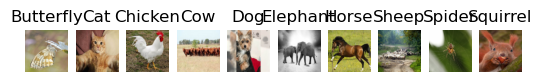

In [4]:
#
labels = np.unique(data['label'])
 
fig, axes = plt.subplots(1, len(labels))

for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

Print the shape of one of the images to ensure it is the correct size. 

In [5]:
x_train.shape

(9000, 128, 128, 3)

## Neural network
CNN consists of conv2D layers followed by maxpooling2D layers. For this project I decided to include 3 of these combinations. 

In [6]:
CNN = Sequential([
    Conv2D(32,kernel_size=(3, 3), activation="relu", input_shape=[width, width, 3]),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64,kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
        
    Conv2D(64,kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    
    Dense(64,activation='relu'),
    Dense(len(np.unique(y_train)),activation='softmax'),
])

Below is a summary of the neural network built. 

In [7]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        3

The model is compiled according with standard imputs. One option that is different is the learning rate. This was set because there was some issues having the model train. 

In [8]:
# model compilation
opt = keras.optimizers.Adam(learning_rate=0.001)
CNN.compile(optimizer=opt,
                loss='SparseCategoricalCrossentropy',
                metrics=["accuracy"],
                )

To save time a callback is made to stop the model early if the accuracy of the training is not raised after 3 epochs. 

In [9]:
callback = keras.callbacks.EarlyStopping(
    monitor = "accuracy",
    min_delta = 0.03,
    patience = 3
)

The last step of the process is to train the model. The options for the training is seen below. 

In [10]:
epochs = 30
batch_size = 64

history = CNN.fit(x=x_train, 
                    y=y_train, 
                    epochs=epochs,
                    shuffle= True,
                    batch_size=batch_size,
                    validation_split=0.15,
                    callbacks=callback                    
       )

Epoch 1/30
120/120 [==============================] - 89s 732ms/step - loss: 2.1989 - accuracy: 0.1603 - val_loss: 2.0731 - val_accuracy: 0.2081
Epoch 2/30
120/120 [==============================] - 78s 654ms/step - loss: 1.9205 - accuracy: 0.3149 - val_loss: 1.7812 - val_accuracy: 0.3733
Epoch 3/30
120/120 [==============================] - 82s 686ms/step - loss: 1.6221 - accuracy: 0.4386 - val_loss: 1.5877 - val_accuracy: 0.4363
Epoch 4/30
120/120 [==============================] - 85s 706ms/step - loss: 1.3978 - accuracy: 0.5220 - val_loss: 1.5356 - val_accuracy: 0.4556
Epoch 5/30
120/120 [==============================] - 81s 672ms/step - loss: 1.2260 - accuracy: 0.5745 - val_loss: 1.5091 - val_accuracy: 0.4800
Epoch 6/30
120/120 [==============================] - 79s 656ms/step - loss: 1.0887 - accuracy: 0.6316 - val_loss: 1.5783 - val_accuracy: 0.4756
Epoch 7/30
120/120 [==============================] - 80s 667ms/step - loss: 0.9457 - accuracy: 0.6791 - val_loss: 1.5259 - val_ac

To visualize how the training went the accuracy and loss are plotted below. 

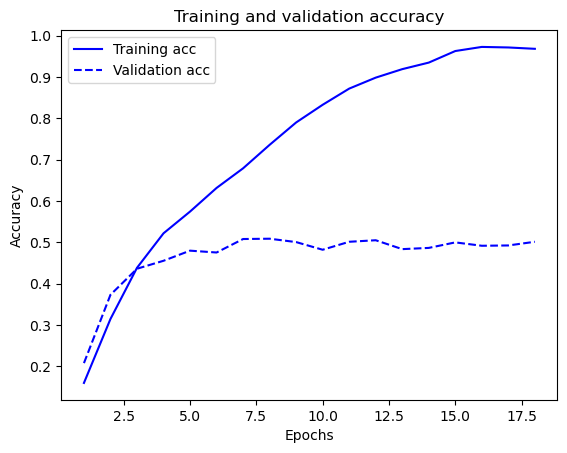

In [11]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.figure(2)
plt.plot(epochs, acc, "b", label="Training acc")
plt.plot(epochs, val_acc, "b--", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

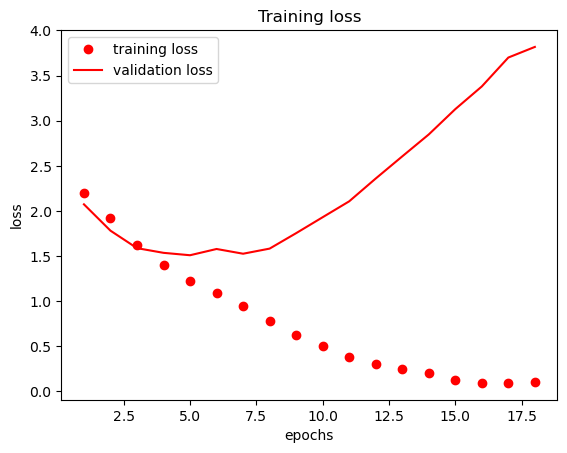

In [12]:
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

plt.figure()
plt.plot(epochs, loss, "ro", label = "training loss")
plt.plot(epochs, val_loss, "r", label = "validation loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss')
plt.legend()
plt.show()

To get a sense of how the model does, 6 images are plotted below. 

1/1 [==============================] - 0s 120ms/step


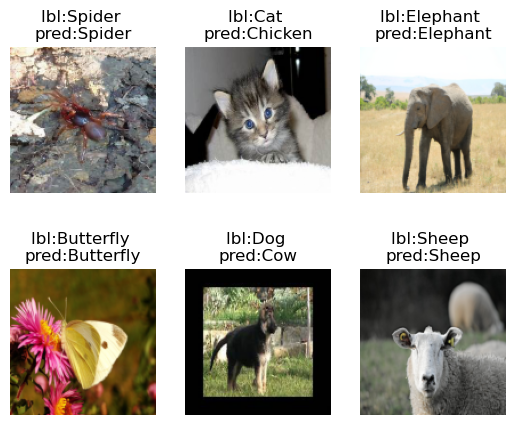

In [13]:
X, Y = shuffle(x_test, y_test)

sample_data = X[0:9]
predictions = CNN.predict(sample_data)

plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title(f'lbl:{train_labels[Y[i]]} \npred:{train_labels[predictions[i].argmax()]}')
    plt.subplots_adjust(hspace=0.5)
    plt.axis('off')
    
    plt.imshow(X[i])



To see where the model does not work well, 12 random wrong predictions are plotted below. 

32/32 [==============================] - 2s 71ms/step


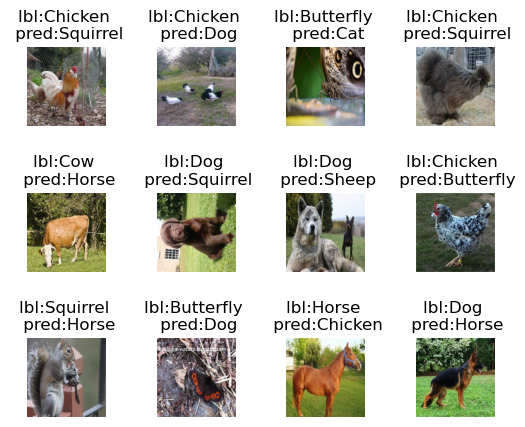

In [14]:
X, Y = shuffle(x_test, y_test)
predictions = CNN.predict(X)
idx = []
for i in range(0,len(predictions)):
    if predictions[i].argmax() != Y[i]:
        idx.append(i)


        if len(idx) == 12:
            break
plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)

    plt.title(f'lbl:{train_labels[Y[idx[i]]]} \n pred:{train_labels[predictions[idx[i]].argmax()]}')
    plt.subplots_adjust(hspace=0.85)
    plt.axis('off')
    plt.imshow(X[idx[i]])

To get a better sense of where the model does not perform well, a confusion matrix is shown below. 

32/32 [==============================] - 3s 78ms/step


<AxesSubplot:xlabel='actal', ylabel='predicted'>

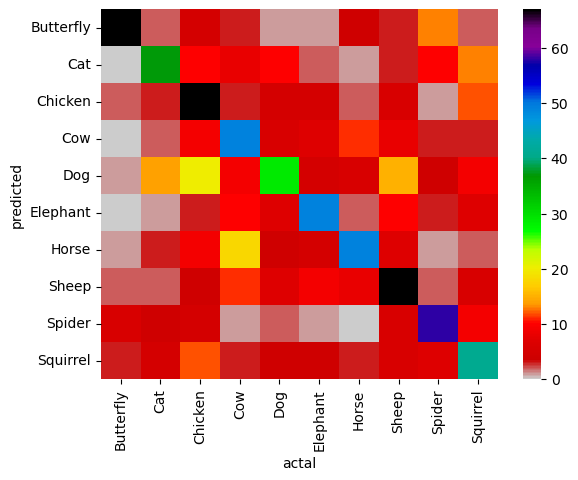

In [15]:
pred = CNN.predict(x_test)
cm = confusion_matrix(y_test, pred.argmax(axis=1))
cm = pd.DataFrame(cm, columns=train_labels, index=train_labels)
cm = cm.rename_axis("predicted")
cm = cm.rename_axis('actal', axis='columns')
sns.heatmap(
    cm,
    cmap = 'nipy_spectral_r'
    )